# PasswordCrackTimePrediction:

## 1- Import Libraries:

In [3]:
import math
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


## 2- Read Dataset & Viewing

In [4]:

path = './Tranining_and_Building_Models'
df = pd.read_csv(f"{path}/dataset/dataset.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   password        100000 non-null  object 
 1   strength        100000 non-null  float64
 2   length          100000 non-null  int64  
 3   class_strength  100000 non-null  object 
 4   entropy         100000 non-null  float64
 5   crack_time_sec  100000 non-null  float64
 6   crack_time      100000 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 5.3+ MB


In [6]:
df.describe()

,strength,length,entropy,crack_time_sec
count,100000.000000,100000.000000,100000.000000,1.000000e+05
mean,0.495961,13.619160,53.805484,4.619530e+99
std,0.278578,7.103637,38.762932,7.218766e+101
min,0.000000,4.000000,8.000000,1.280000e-07
25%,0.249543,8.000000,24.000000,8.388608e-03
50%,0.507625,12.000000,43.019550,4.458050e+03
75%,0.726394,17.000000,69.486868,4.136201e+11
max,0.999480,63.000000,376.568635,1.141365e+104


## 3- Preprocessing:

In [7]:
df = df.drop_duplicates()

In [8]:
df = df.drop_duplicates()
df2 = df[['password', 'strength', 'length', 'entropy', 'crack_time_sec']].copy()
df2.columns = ['password', 'strength', 'length', 'entropy', 'time']


### 3.1- Calculate our entropy:

In [9]:
def calculate_entropy(password):
  lw, up, dg, sp = 0, 0, 0, 0
  for char in password:
    if char.islower(): lw += 1
    elif char.isupper(): up += 1
    elif char.isdigit(): dg += 1
    else: sp += 1
  csz = 0
  if lw > 0: csz += 26
  elif up > 0: csz += 26
  elif dg > 0: csz += 10
  elif sp > 0: csz += 32

  character_set_size = csz
  password_length = len(password)
  entropy = math.log2(character_set_size ** password_length)
  return entropy


In [10]:
passwords = df2['password'].values
new_entropy = []
for password in passwords:
  entropy = calculate_entropy(password)
  new_entropy.append(entropy)


/tmp/ipykernel_60060/3417013649.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  spearman_corr = df2.corr(method='spearman')


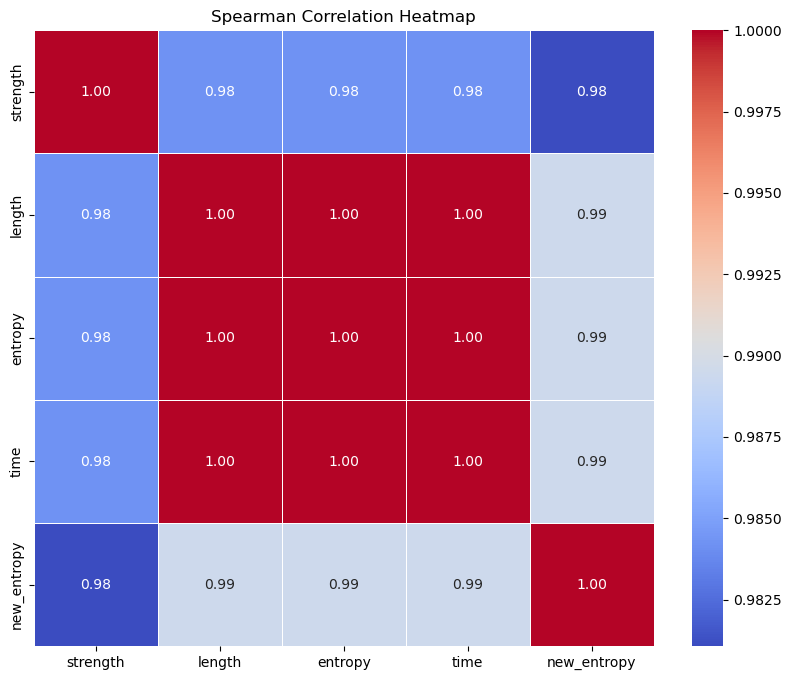

In [11]:
df2['new_entropy'] = new_entropy

spearman_corr = df2.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Spearman Correlation Heatmap')
plt.show()


### 3.2 Processing `crack_time_sec` column to become `time` and `exponent`

In [12]:
df2['new_entropy'] = new_entropy
def transform_value(value):
  exponent = int(round(np.log10(abs(value))))
  normalized_value = value / 10**exponent
  return normalized_value, exponent


In [13]:
ut = df2['time'].value_counts().index
power_list, time_list = [], []
for i in ut:
  nv, p = transform_value(i)
  power_list.append(p)
  time_list.append(nv)


In [14]:
for i in range(len(ut)):
  old_time = ut[i]
  exponent = power_list[i]
  n_time = time_list[i]
  indices = df2[df2['time']==old_time].index
  df2.loc[indices, 'new_time'] = n_time
  df2.loc[indices, 'exponent'] = exponent


In [15]:
df2.head()11

,password,strength,length,entropy,time,new_entropy,new_time,exponent
0,bybee,0.088053,5,11.60964,1.562500e-06,23.502199,1.5625,-6.0
1,n3m0,0.088889,4,8.00000,1.280000e-07,18.801759,1.2800,-7.0
2,2509,0.088889,4,8.00000,1.280000e-07,13.287712,1.2800,-7.0
3,4622,0.070443,4,8.00000,1.280000e-07,13.287712,1.2800,-7.0
4,shrk,0.088889,4,8.00000,1.280000e-07,18.801759,1.2800,-7.0


In [16]:
df2.drop(columns=['entropy', 'time'], inplace=True)
df2.columns = ['password', 'strength', 'length', 'entropy', 'time', 'exponent']
df2.head()11


,password,strength,length,entropy,time,exponent
0,bybee,0.088053,5,23.502199,1.5625,-6.0
1,n3m0,0.088889,4,18.801759,1.2800,-7.0
2,2509,0.088889,4,13.287712,1.2800,-7.0
3,4622,0.070443,4,13.287712,1.2800,-7.0
4,shrk,0.088889,4,18.801759,1.2800,-7.0


In [17]:
df2.describe()

,strength,length,entropy,time,exponent
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,0.495961,13.619160,62.651403,1.247337,6.881640
std,0.278582,7.103744,33.863559,0.730870,11.673387
min,0.000000,4.000000,13.287712,0.330049,-7.000000
25%,0.249543,8.000000,37.603518,0.524288,-2.000000
50%,0.507625,12.000000,56.405277,1.029456,4.000000
75%,0.726394,17.000000,79.907475,1.937102,12.000000
max,0.999480,63.000000,296.127702,3.078060,104.000000


## 4- Prediction:

### 4.1- `strength` Prediction:
using RandomForestRegression

In [18]:
# password 	strength 	length 	entropy 	time 	exponent
X = df2[['length', 'entropy']]
y = df2['strength']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

strength_model = RandomForestRegressor(n_estimators=250,random_state=42)
strength_model.fit(X_train, y_train)
y_pred = strength_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
res = r2_score(y_pred, y_test)
print(f'MSE:\t{mse}')
print(f'R2:\t{res}')

# Results:
# MSE:	0.0015916514295602048
# R2:	0.9792158946942322


MSE:	0.0015916514295602048
R2:	0.9792158946942322


### 4.2 `exponent` Prediction:

In [19]:
# password 	strength 	length 	entropy 	time 	exponent
X = df2[['length', 'entropy', 'strength']]
y = df2['exponent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 ,random_state=42)

exp_model = RandomForestRegressor(n_estimators=100, random_state=42)
exp_model.fit(X_train, y_train)
y_pred = exp_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
res = r2_score(y_pred, y_test)
print(f'MSE:\t{mse}')
print(f'R2:\t{res}')

# Result:
# MSE:	0.003395219999999995
# R2:	0.9999744464096049


MSE:	0.003920219999999993
R2:	0.9999704886965889


### 4.3 `time` Prediction:

In [20]:
# password 	strength 	length 	entropy 	time	exponent
X = df2[['length', 'entropy', 'strength', 'exponent']]
y = df2['time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 ,random_state=42)

time_model = RandomForestRegressor(n_estimators=100, random_state=42)
time_model.fit(X_train, y_train)
y_pred = time_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
res = r2_score(y_pred, y_test)
print(f'MSE:\t{mse}')
print(f'R2:\t{res}')

# Result:
# MSE:	0.0007410281319479788
# R2:	0.998631121150848


MSE:	0.0007308766884319349
R2:	0.9986499269569981


### 4.4 Save Models:

In [ ]:
joblib.dump(strength_model, '../models/strength_model.pkl')
joblib.dump(exp_model, '../models/exponent_model.pkl')
joblib.dump(time_model, '../models/time_model.pkl')


## 5- Applying Prediction:

### 5.1 Read new Password-List

In [64]:
pswd = []
c = 0
with open(f'{path}/input.txt', 'rb') as f:
  for line in f:
    c += 1
    try:
      decoded_line = line.decode('utf-8')
    except UnicodeDecodeError:
      decoded_line = line.decode('latin-1')
    finally:
      decoded_line = decoded_line.strip()
      pswd.append(decoded_line)
      if c >= 1000:
        break
df3 = pd.DataFrame(pswd, columns=['password'])

Count: 800
C: 9801


In [67]:
df3.loc[0, 'password'] = 'sa1ah421yaf'
df3.head()


,password
0,sa1ah421yaf
1,ADRIANA
2,101087
3,trish
4,tabby


### 5.2 Functions:

In [68]:
dftmp = df3.copy()

entropy_list, length_list = [], []
for password in dftmp['password'].values:
  length_list.append(len(password))
  entropy = calculate_entropy(password)
  entropy_list.append(entropy)
dftmp['length'] = length_list
dftmp['entropy'] = entropy_list

strength = strength_model.predict(dftmp.drop(columns=['password']))
dftmp['strength'] = strength

exponent = exp_model.predict(dftmp.drop(columns=['password']))
dftmp['exponent'] = exponent

time_val = time_model.predict(dftmp.drop(columns=['password']))
dftmp['time'] = time_val

time_sec = []
for i in dftmp.index:
  ex = dftmp.loc[i, 'exponent']
  ti = dftmp.loc[i, 'time']
  time_sec.append(ti * 10**ex)
dftmp['time_sec'] = time_sec


In [69]:
dftmp.head()


,password,length,entropy,strength,exponent,time,time_sec
0,sa1ah421yaf,11,51.704837,0.423641,2.0,1.426558,142.655835
1,ADRIANA,7,32.903078,0.188037,-3.0,0.411771,0.000412
2,101087,6,19.931569,0.122991,-5.0,2.332800,0.000023
3,trish,5,23.502199,0.091264,-6.0,1.562500,0.000002
4,tabby,5,23.502199,0.091264,-6.0,1.562500,0.000002


In [46]:
dftmp['exponent'].value_counts()


-5.0     2657
-3.0     1877
-2.0     1533
-1.0      748
-6.0      538
 1.0      427
 2.0      116
 4.0       39
-7.0       31
 5.0       17
 7.0        9
 8.0        5
 12.0       1
 10.0       1
 13.0       1
Name: exponent, dtype: int64

In [98]:
def convert_seconds_to_time(seconds):
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    days, hours = divmod(hours, 24)
    months, days = divmod(days, 30)
    years, months = divmod(months, 12)
    centuries, years = divmod(years, 100)
    return int(centuries), int(years), int(months), int(days), int(hours), int(minutes), seconds

def result_of_time_processing(seconds):
    label = {
        0:{ # 'century'
            'singl':'Century',
            'plural': 'Centuries'
        },
        1:{ # 'year'
            'singl': 'Year',
            'plural': 'Years'
        },
        2:{ # 'month'
            'singl': 'Month',
            'plural': 'Months'
        },
        3:{ # 'day'
            'singl': 'Day',
            'plural': 'Days'
        },
        4:{ # 'hour'
            'singl': 'Hour',
            'plural': 'Hours'
        },
        5:{ # 'minut'
            'singl': 'Minut',
            'plural': 'Minuts'
        },
        6:{ # 'second'
            'singl': 'Second',
            'plural': 'Seconds'
        }
    }
    
    res = list(convert_seconds_to_time(seconds))
    txt = []
    for i in range(len(res)):
        val = res[i]
        if val > 0:
            if val > 1:
                t = f"'{val}' {label[i]['plural']}"
            else:
                t = f"'{val}' {label[i]['singl']}"
            txt.append(t)
    if len(txt) > 1:
        result = ", ".join(txt[:-1])
        result += f", And {txt[-1]}"
    else:
        result = ", ".join(txt)
    return result


In [104]:
result_of_time_processing(max(dftmp['time_sec'].values))

"'6324' Centuries, '97' Years, '6' Months, '20' Days, '19' Hours, '20' Minuts, And '48.31640625' Seconds"